In [2]:
# Analysis of Imbalance Ratio Effects on Loss Landscape and Overfitting

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
# Set TensorFlow deterministic operations
tf.config.experimental.enable_op_determinism()
# Set Python's random seed
import random
random.seed(42)
# Set environment variables for reproducibility
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = '42'

In [5]:
# TODO: add weighting to the samples based on reciprocal of their imbalance
# TODO: debug current issue


class ImbalancedCircleDataset:
    """
    Generates a simple 2D regression dataset with imbalanced frequency bins.
    - Features: (x, y) coordinates
    - Target: label = distance to center (sqrt(x^2 + y^2)) + noise
    - Two bins: frequent (close to origin) and rare (further from origin)
    """
    
    def __init__(
            self, 
            num_freq_samples: int = 10000,  # Number of samples in the frequent bin
            imbalance_ratio: float = 1.0,  # Ratio of frequent to rare samples
            freq_max_radius: float = 0.5,  # Max radius for frequent samples (close to center)
            rare_min_radius: float = 0.5,  # Min radius for rare samples (further from center)
            noise_level: float = 0.2,  # Standard deviation of Gaussian noise
            val_size: int = 1000  # Size of validation set (equal number of rare and frequent)
        ):
        """
        Initialize the dataset generator.
        
        Args:
            num_freq_samples: Number of samples in the frequent bin
            imbalance_ratio: Ratio of frequent to rare samples
            freq_max_radius: Maximum radius from origin for frequent samples
            rare_min_radius: Minimum radius from origin for rare samples
            noise_level: Standard deviation of Gaussian noise added to targets
            val_size: Size of validation set (will have val_size/2 samples from each bin)
        """
        self.num_freq_samples = num_freq_samples
        self.imbalance_ratio = imbalance_ratio
        self.freq_max_radius = freq_max_radius
        self.rare_min_radius = rare_min_radius
        self.noise_level = noise_level
        self.val_size = val_size
        self._generate_base_dataset()
    
    def _generate_base_dataset(self) -> None:
        """
        Generate the base dataset with frequent and rare samples.
        This is called once during initialization to maintain consistency.
        """
        # Create the frequent samples (close to origin)
        num_freq = self.num_freq_samples
        
        # Generate random points with radius from 0 to freq_max_radius
        r_freq = np.random.uniform(0, self.freq_max_radius, num_freq)
        # Generate random points with angle from 0 to 2*pi
        theta_freq = np.random.uniform(0, 2*np.pi, num_freq)
        
        # converting from polar to cartesian coords
        x_freq = r_freq * np.cos(theta_freq)
        y_freq = r_freq * np.sin(theta_freq)
        
        # Create rare samples (further from origin) - same number as frequent initially
        num_potential_rare = self.num_freq_samples  # Same as frequent samples
        
        # Generate random points rare samples with radius from rare_min_radius to 1.0
        r_rare = np.random.uniform(self.rare_min_radius, 1.0, num_potential_rare)

        # Generate random points with angle from 0 to 2*pi
        theta_rare = np.random.uniform(0, 2*np.pi, num_potential_rare)
        
        # converting from polar to cartesian coords
        x_rare = r_rare * np.cos(theta_rare)
        y_rare = r_rare * np.sin(theta_rare)
        
        # Calculate targets: label = distance to center (sqrt(x^2 + y^2)) + noise
        # Add Gaussian noise to make the dataset more realistic
        noise_freq = np.random.normal(0, self.noise_level, num_freq)
        noise_rare = np.random.normal(0, self.noise_level, num_potential_rare)
        
        targets_freq = np.sqrt(x_freq**2 + y_freq**2) + noise_freq
        targets_rare = np.sqrt(x_rare**2 + y_rare**2) + noise_rare
        
        # Store all potential samples
        self.x_freq, self.y_freq = x_freq, y_freq
        self.targets_freq = targets_freq
        self.x_rare_all, self.y_rare_all = x_rare, y_rare
        self.targets_rare_all = targets_rare
        
        # Generate validation set with equal number of rare and frequent samples
        val_samples_per_class = self.val_size // 2
        
        # Ensure we have enough samples
        val_samples_per_class = min(val_samples_per_class, num_freq, num_potential_rare)
        
        # Select validation samples (deterministically)
        freq_val_indices = np.linspace(0, num_freq-1, val_samples_per_class, dtype=int)
        rare_val_indices = np.linspace(0, num_potential_rare-1, val_samples_per_class, dtype=int)
        
        # Create validation set
        self.X_val = np.column_stack([
            np.concatenate([x_freq[freq_val_indices], x_rare[rare_val_indices]]),
            np.concatenate([y_freq[freq_val_indices], y_rare[rare_val_indices]])
        ])
        
        self.y_val = np.concatenate([
            targets_freq[freq_val_indices], 
            targets_rare[rare_val_indices]
        ])
        
        # Create masks for the validation set
        self.val_freq_mask = np.concatenate([
            np.ones(val_samples_per_class, dtype=bool),
            np.zeros(val_samples_per_class, dtype=bool)
        ])
        self.val_rare_mask = ~self.val_freq_mask
        
        # Remove validation samples from training pool
        self.x_freq_train = np.delete(x_freq, freq_val_indices)
        self.y_freq_train = np.delete(y_freq, freq_val_indices)
        self.targets_freq_train = np.delete(targets_freq, freq_val_indices)
        
        self.x_rare_all_train = np.delete(x_rare, rare_val_indices)
        self.y_rare_all_train = np.delete(y_rare, rare_val_indices)
        self.targets_rare_all_train = np.delete(targets_rare, rare_val_indices)
    
    def get_dataset(self, imbalance_ratio: Optional[float] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Get training dataset with specified imbalance ratio.
        
        Args:
            imbalance_ratio: Override the default imbalance ratio if provided
        
        Returns:
            Tuple of (features, targets) where features has shape (n_samples, 2)
            and targets has shape (n_samples,)
        """
        if imbalance_ratio is None:
            imbalance_ratio = self.imbalance_ratio
        
        # Calculate how many rare samples to include
        num_freq = len(self.x_freq_train)
        num_rare = int(num_freq / imbalance_ratio)
        
        # Ensure we have at least 1 rare sample, but not more than available
        num_rare = max(1, min(num_rare, len(self.x_rare_all_train)))
        
        # Handle the case where there are no rare samples available
        if len(self.x_rare_all_train) == 0:
            # Just use frequent samples only
            X = np.column_stack([self.x_freq_train, self.y_freq_train])
            y = self.targets_freq_train
            
            # Create masks for visualization
            self.freq_mask = np.ones(num_freq, dtype=bool)
            self.rare_mask = np.zeros(num_freq, dtype=bool)
            
            return X, y
        
        # Select rare samples (deterministically)
        indices = np.linspace(0, len(self.x_rare_all_train)-1, num_rare, dtype=int)
        x_rare = self.x_rare_all_train[indices]
        y_rare = self.y_rare_all_train[indices]
        targets_rare = self.targets_rare_all_train[indices]
        
        # Combine frequent and rare samples
        X = np.column_stack([
            np.concatenate([self.x_freq_train, x_rare]),
            np.concatenate([self.y_freq_train, y_rare])
        ])
        
        # Target is distance to center + noise (noise already added during generation)
        y = np.concatenate([self.targets_freq_train, targets_rare])
        
        # Create masks for visualization
        self.freq_mask = np.concatenate([np.ones(num_freq, dtype=bool), 
                                        np.zeros(num_rare, dtype=bool)])
        self.rare_mask = ~self.freq_mask
        
        return X, y
    
    def get_validation_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Get the validation dataset with balanced rare and frequent samples.
        
        Returns:
            Tuple of (X_val, y_val) for validation
        """
        return self.X_val, self.y_val
    
    def plot_dataset(self, X: np.ndarray, y: np.ndarray, title: str = "Dataset Visualization") -> None:
        """
        Plot the dataset showing frequent and rare samples.
        
        Args:
            X: Feature array of shape (n_samples, 2)
            y: Target array of shape (n_samples,)
            title: Plot title
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # First subplot: Training data
        # Plot frequent samples
        scatter1 = ax1.scatter(X[self.freq_mask, 0], X[self.freq_mask, 1], 
                   c=y[self.freq_mask], cmap='Blues', s=50, alpha=0.8,
                   label=f'Frequent ({np.sum(self.freq_mask)} samples)')
        
        # Plot rare samples
        scatter2 = ax1.scatter(X[self.rare_mask, 0], X[self.rare_mask, 1], 
                   c=y[self.rare_mask], cmap='Reds', s=80, alpha=0.8, marker='x',
                   label=f'Rare ({np.sum(self.rare_mask)} samples)')
        
        fig.colorbar(scatter1, ax=ax1, label='Target value (distance to center + noise)')
        ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        
        # Draw circle at radius 0.5 to show the boundary
        circle1 = plt.Circle((0, 0), self.freq_max_radius, fill=False, color='green', linestyle='--')
        ax1.add_patch(circle1)
        
        ax1.set_title(f"Training {title}")
        ax1.set_xlabel('X coordinate')
        ax1.set_ylabel('Y coordinate')
        ax1.legend()
        ax1.axis('equal')
        ax1.grid(alpha=0.3)
        
        # Second subplot: Validation data
        # Plot frequent validation samples
        scatter3 = ax2.scatter(self.X_val[self.val_freq_mask, 0], self.X_val[self.val_freq_mask, 1], 
                   c=self.y_val[self.val_freq_mask], cmap='Blues', s=50, alpha=0.8,
                   label=f'Frequent validation ({np.sum(self.val_freq_mask)} samples)')
        
        # Plot rare validation samples
        scatter4 = ax2.scatter(self.X_val[self.val_rare_mask, 0], self.X_val[self.val_rare_mask, 1], 
                   c=self.y_val[self.val_rare_mask], cmap='Reds', s=80, alpha=0.8, marker='x',
                   label=f'Rare validation ({np.sum(self.val_rare_mask)} samples)')
        
        fig.colorbar(scatter3, ax=ax2, label='Target value (distance to center + noise)')
        ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        
        # Draw circle at radius 0.5 to show the boundary
        circle2 = plt.Circle((0, 0), self.freq_max_radius, fill=False, color='green', linestyle='--')
        ax2.add_patch(circle2)
        
        ax2.set_title(f"Validation")
        ax2.set_xlabel('X coordinate')
        ax2.set_ylabel('Y coordinate')
        ax2.legend()
        ax2.axis('equal')
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()


def create_simple_model() -> tf.keras.Model:
    """
    Create a very simple neural network with only 2 parameters.
    
    Returns:
        A TensorFlow model with 2 trainable parameters
    """
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        tf.keras.layers.Dense(
            1, 
            use_bias=False, 
            activation=None, 
            kernel_initializer='zeros'
        )
    ])
    
    # Verify we have exactly 2 parameters (2 weights, no bias)
    assert len(model.trainable_variables) == 1
    assert model.trainable_variables[0].shape == (2, 1)  # weights
    assert model.trainable_variables[0].shape[0] * model.trainable_variables[0].shape[1] == 2  # total of 2 parameters
    
    return model


def train_model(
    model: tf.keras.Model, 
    X_train: np.ndarray, y_train: np.ndarray,
    X_val: np.ndarray, y_val: np.ndarray,
    epochs: int = 200, 
    batch_size: int = 32,
    lr: float = 0.01
) -> Dict[str, List[float]]:
    """
    Train the model and track history.
    
    Args:
        model: TensorFlow model to train
        X_train, y_train: Training data
        X_val, y_val: Validation data
        epochs: Number of training epochs
        batch_size: Batch size for training
        lr: Learning rate for the optimizer
        
    Returns:
        Dictionary with training history
    """
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )
    
    # Manual training to track parameters
    train_losses = []
    val_losses = []
    param_history = []
    
    # Convert to tensors
    X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
    y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.float32)
    
    # Training loop
    for epoch in range(epochs):
        # Shuffle training data
        indices = tf.random.shuffle(tf.range(len(X_train)))
        X_shuffled = tf.gather(X_train_tf, indices)
        y_shuffled = tf.gather(y_train_tf, indices)
        
        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            with tf.GradientTape() as tape:
                y_pred = model(X_batch, training=True)
                loss = tf.reduce_mean(tf.square(y_pred - tf.expand_dims(y_batch, -1)))
                
            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Evaluate on full datasets
        y_train_pred = model(X_train_tf, training=False)
        train_loss = tf.reduce_mean(tf.square(y_train_pred - tf.expand_dims(y_train_tf, -1)))
        
        y_val_pred = model(X_val_tf, training=False)
        val_loss = tf.reduce_mean(tf.square(y_val_pred - tf.expand_dims(y_val_tf, -1)))
        
        # Save history
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
        
        # Save parameter values
        w = model.trainable_variables[0].numpy().flatten()
        param_history.append(w)  # Just save the weights
        
        # Print results for each epoch
        print(f"Epoch {epoch+1}/{epochs} - train_loss: {float(train_loss):.6f} - val_loss: {float(val_loss):.6f} - weights: [{w[0]:.4f}, {w[1]:.4f}]")
    
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'params': np.array(param_history)
    }
    
    return history


def compute_loss_landscape(
    model: tf.keras.Model, 
    X: np.ndarray, y: np.ndarray,
    w1_range: Tuple[float, float] = (-5, 5),
    w2_range: Tuple[float, float] = (-5, 5),
    grid_size: float = 0.001,  # Size of each grid cell for high resolution
    batch_size: int = 1000  # Process parameters in batches for speed
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute the loss landscape by varying the two model weights.
    
    Args:
        model: TensorFlow model with 2 weights
        X, y: Dataset to compute loss on
        w1_range: Range for first weight parameter
        w2_range: Range for second weight parameter
        grid_size: Size of each grid cell for more detailed landscape
        batch_size: Number of parameter combinations to process at once
        
    Returns:
        Grid of parameter values and corresponding losses
    """
    # Calculate number of points based on grid size
    resolution_w1 = int((w1_range[1] - w1_range[0]) / grid_size) + 1
    resolution_w2 = int((w2_range[1] - w2_range[0]) / grid_size) + 1
    
    # Create parameter grid
    w1_vals = np.linspace(w1_range[0], w1_range[1], resolution_w1)
    w2_vals = np.linspace(w2_range[0], w2_range[1], resolution_w2)
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    
    # Original parameters
    original_w = model.trainable_variables[0].numpy().copy()
    
    # Convert data to tensors
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
    
    # Compute loss for each parameter combination
    Z = np.zeros_like(W1)
    
    # Flatten parameter grid for batch processing
    param_combinations = np.column_stack((W1.flatten(), W2.flatten()))
    total_combinations = len(param_combinations)
    
    # Process in batches
    for i in range(0, total_combinations, batch_size):
        # Get current batch of parameters
        batch_params = param_combinations[i:min(i+batch_size, total_combinations)]
        batch_losses = []
        
        # Process each parameter set in the batch
        for params in batch_params:
            w1, w2 = params
            # Set model parameters
            model.trainable_variables[0].assign([[w1], [w2]])
            
            # Compute loss
            y_pred = model(X_tf, training=False)
            loss = tf.reduce_mean(tf.square(y_pred - tf.expand_dims(y_tf, -1)))
            batch_losses.append(float(loss.numpy()))
        
        # Store batch results
        start_idx = i
        end_idx = min(i+batch_size, total_combinations)
        flat_indices = np.arange(start_idx, end_idx)
        
        # Convert flat indices back to 2D indices
        rows = flat_indices // W1.shape[1]
        cols = flat_indices % W1.shape[1]
        
        # Update Z matrix with computed losses
        for k, (r, c) in enumerate(zip(rows, cols)):
            Z[r, c] = batch_losses[k]
    
    # Restore original parameters
    model.trainable_variables[0].assign(original_w)
    
    return W1, W2, Z

def plot_loss_landscape(
    W1: np.ndarray, 
    W2: np.ndarray, 
    Z: np.ndarray, 
    param_history: Optional[np.ndarray] = None,
    title: str = "Loss Landscape") -> None:
    """
    Plot the loss landscape with optional training trajectory.
    
    Args:
        W1, W2: Parameter grid for the two weights
        Z: Loss values at each point in the grid
        param_history: Optional trajectory of parameters during training
        title: Plot title
    """
    # Create a figure with 4 subplots (1 wide 2D at top, 3 3D views at bottom)
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 2])
    
    # 2D contour plot (wide, spanning all columns at top)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Use a high-contrast colormap (red-blue)
    cmap = plt.cm.RdBu_r
    
    # Plot loss landscape as contour with high contrast
    contour = ax1.contourf(W1, W2, Z, 50, cmap=cmap)
    plt.colorbar(contour, ax=ax1, label='Loss (MSE)')
    
    # Add contour lines
    contour_lines = ax1.contour(W1, W2, Z, 15, colors='black', alpha=0.5, linewidths=0.5)
    ax1.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
    
    # Plot optimization trajectory if provided
    if param_history is not None:
        ax1.plot(param_history[:, 0], param_history[:, 1], 'lime', linewidth=2, alpha=0.7)
        ax1.scatter(param_history[0, 0], param_history[0, 1], c='blue', s=100, 
                  label='Start', zorder=10)
        ax1.scatter(param_history[-1, 0], param_history[-1, 1], c='red', s=100, 
                  label='End', zorder=10)
    
    ax1.set_title(f"2D {title}")
    ax1.set_xlabel('Weight 1 (w1)')
    ax1.set_ylabel('Weight 2 (w2)')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 3D surface plots with different viewing angles
    view_angles = [(30, 45), (0, 0), (60, 30)]
    
    for i, angles in enumerate(view_angles):
        ax = fig.add_subplot(gs[1, i], projection='3d')
        
        # Plot surface with high contrast colormap
        surface = ax.plot_surface(W1, W2, Z, cmap=cmap, alpha=0.8,
                                rstride=1, cstride=1, linewidth=0, antialiased=True)
        
        # Plot optimization trajectory in 3D if provided
        if param_history is not None:
            # Get Z values for the trajectory points by interpolating
            from scipy.interpolate import interpn
            points = (np.linspace(W1.min(), W1.max(), W1.shape[0]), 
                     np.linspace(W2.min(), W2.max(), W2.shape[0]))
            trajectory_z = interpn(points, Z, 
                                  param_history[:, [0, 1]], 
                                  method='linear', 
                                  bounds_error=False, 
                                  fill_value=None)
            
            ax.plot(param_history[:, 0], param_history[:, 1], trajectory_z, 
                    'lime', linewidth=2, alpha=0.7)
            ax.scatter(param_history[0, 0], param_history[0, 1], trajectory_z[0], 
                       c='blue', s=100, zorder=10)
            ax.scatter(param_history[-1, 0], param_history[-1, 1], trajectory_z[-1], 
                       c='red', s=100, zorder=10)
        
        # Set view angle for this subplot
        ax.view_init(elev=angles[0], azim=angles[1])
        
        # Add a wireframe to better visualize bumps and jumps
        ax.plot_wireframe(W1, W2, Z, color='black', alpha=0.1, rstride=10, cstride=10)
        
        ax.set_title(f"3D View (elev={angles[0]}°, azim={angles[1]}°)")
        ax.set_xlabel('Weight 1 (w1)')
        ax.set_ylabel('Weight 2 (w2)')
        ax.set_zlabel('Loss (MSE)')
    
    plt.tight_layout()
    plt.show()

def plot_training_curves(history: Dict[str, List[float]], title: str = "Training and Validation Loss") -> None:
    """
    Plot training and validation loss curves.
    
    Args:
        history: Training history dictionary
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.yscale('log')
    plt.show()


def analyze_imbalance_effects(
    imbalance_ratios: List[float], 
    num_freq_samples: int = 10000,
    freq_max_radius: float = 0.4,
    rare_min_radius: float = 0.6,
    noise_level: float = 0.1,
    val_size: int = 1000,
    epochs: int = 100,
    grid_size: float = 0.001,
    lr: float = 0.01,
    batch_size: int = 64
) -> Dict:
    """
    Analyze the effects of different imbalance ratios on model training.
    
    Args:
        imbalance_ratios: List of imbalance ratios to test
        num_freq_samples: Number of samples for the frequent class
        freq_max_radius: Radius of the frequent class circle
        rare_min_radius: Radius of the rare class circle
        noise_level: Standard deviation of Gaussian noise
        val_size: Size of validation set
        epochs: Number of training epochs
        grid_size: Size of each grid cell for loss landscape
        lr: Learning rate for optimizer
        batch_size: Batch size for training
        
    Returns:
        Dictionary with analysis results
    """
    results = {
        'imbalance_ratios': imbalance_ratios,
        'final_train_loss': [],
        'final_val_loss': [],
        'min_train_loss': [],
        'min_val_loss': [],
        'overfit_degree': [],  # Difference between train and val loss
        'loss_landscapes': []
    }
    
    # Generate base dataset with default imbalance ratio (will be overridden)
    dataset = ImbalancedCircleDataset(
        num_freq_samples=num_freq_samples,
        freq_max_radius=freq_max_radius,
        rare_min_radius=rare_min_radius,
        noise_level=noise_level,
        val_size=val_size
    )
    
    # Get validation data once (remains constant across all imbalance ratios)
    X_val, y_val = dataset.get_validation_data()
    
    total_ratios = len(imbalance_ratios)
    for i, ratio in enumerate(imbalance_ratios):
        print(f"Processing imbalance ratio {ratio}:1 ({i+1}/{total_ratios})")
        
        # Get dataset with current imbalance ratio
        X_train, y_train = dataset.get_dataset(imbalance_ratio=ratio)
        
        print(f"  Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
        # Create and train model
        model = create_simple_model()
        history = train_model(model, X_train, y_train, X_val, y_val, epochs=epochs, lr=lr, batch_size=batch_size)
        
        print(f"  Computing loss landscape for ratio {ratio}:1")
        # Compute loss landscape with more detailed grid
        W1, W2, Z = compute_loss_landscape(model, X_train, y_train, grid_size=grid_size)
        
        # Store results
        results['final_train_loss'].append(history['train_loss'][-1])
        results['final_val_loss'].append(history['val_loss'][-1])
        results['min_train_loss'].append(min(history['train_loss']))
        results['min_val_loss'].append(min(history['val_loss']))
        results['overfit_degree'].append(history['val_loss'][-1] - history['train_loss'][-1])
        results['loss_landscapes'].append((W1, W2, Z, history))
        
        print(f"  Completed ratio {ratio}:1 - Final train loss: {history['train_loss'][-1]:.6f}, val loss: {history['val_loss'][-1]:.6f}")
    
    print(f"Analysis complete for all {total_ratios} imbalance ratios")
    return results



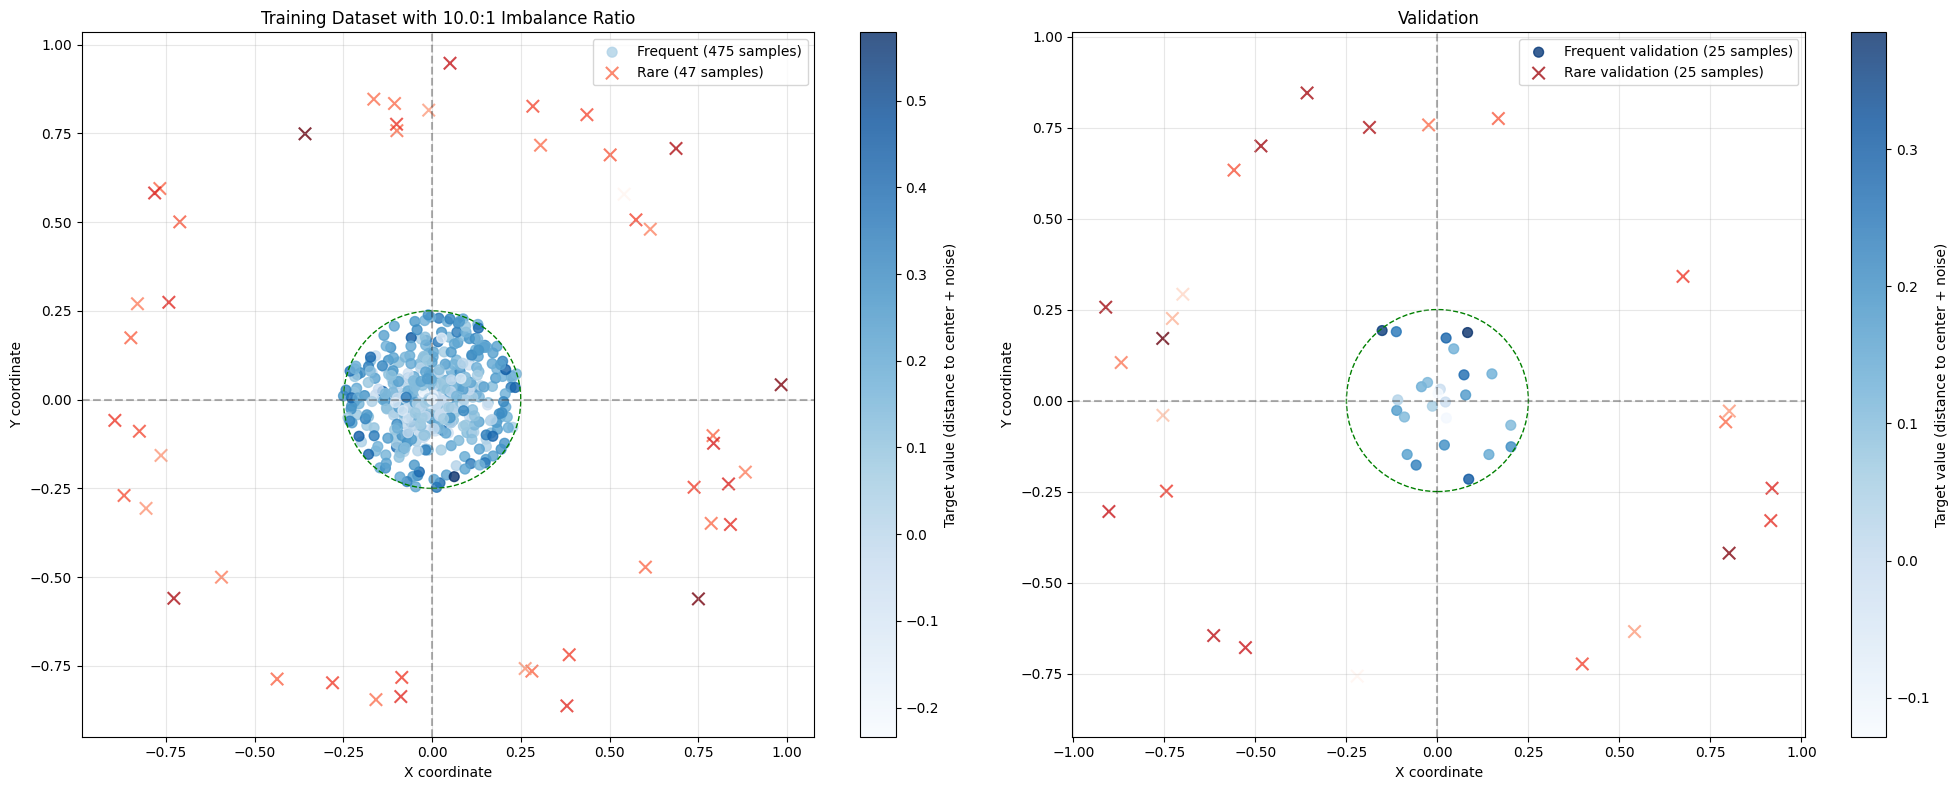

Training model with 522 training samples and 50 validation samples
Epoch 1/50 - train_loss: 0.091794 - val_loss: 0.374357 - weights: [-0.0006, -0.0067]
Epoch 2/50 - train_loss: 0.091727 - val_loss: 0.377494 - weights: [0.0241, -0.0123]
Epoch 3/50 - train_loss: 0.091587 - val_loss: 0.377185 - weights: [0.0274, 0.0053]
Epoch 4/50 - train_loss: 0.091483 - val_loss: 0.374091 - weights: [0.0103, 0.0373]
Epoch 5/50 - train_loss: 0.091438 - val_loss: 0.373309 - weights: [0.0074, 0.0549]
Epoch 6/50 - train_loss: 0.091429 - val_loss: 0.373053 - weights: [0.0063, 0.0611]
Epoch 7/50 - train_loss: 0.091364 - val_loss: 0.374659 - weights: [0.0207, 0.0621]
Epoch 8/50 - train_loss: 0.091406 - val_loss: 0.373794 - weights: [0.0124, 0.0583]
Epoch 9/50 - train_loss: 0.091431 - val_loss: 0.373190 - weights: [0.0070, 0.0586]
Epoch 10/50 - train_loss: 0.091388 - val_loss: 0.373897 - weights: [0.0143, 0.0632]
Epoch 11/50 - train_loss: 0.091314 - val_loss: 0.374995 - weights: [0.0276, 0.0864]
Epoch 12/50 - t

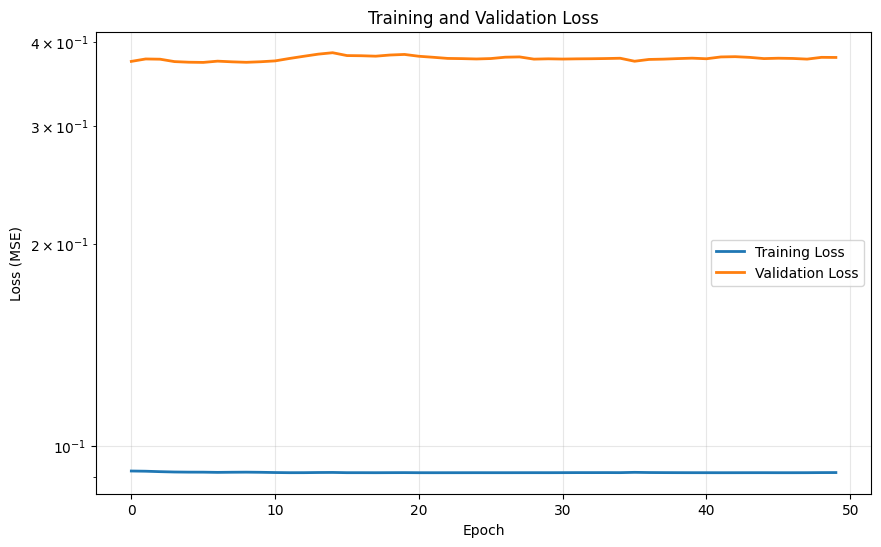

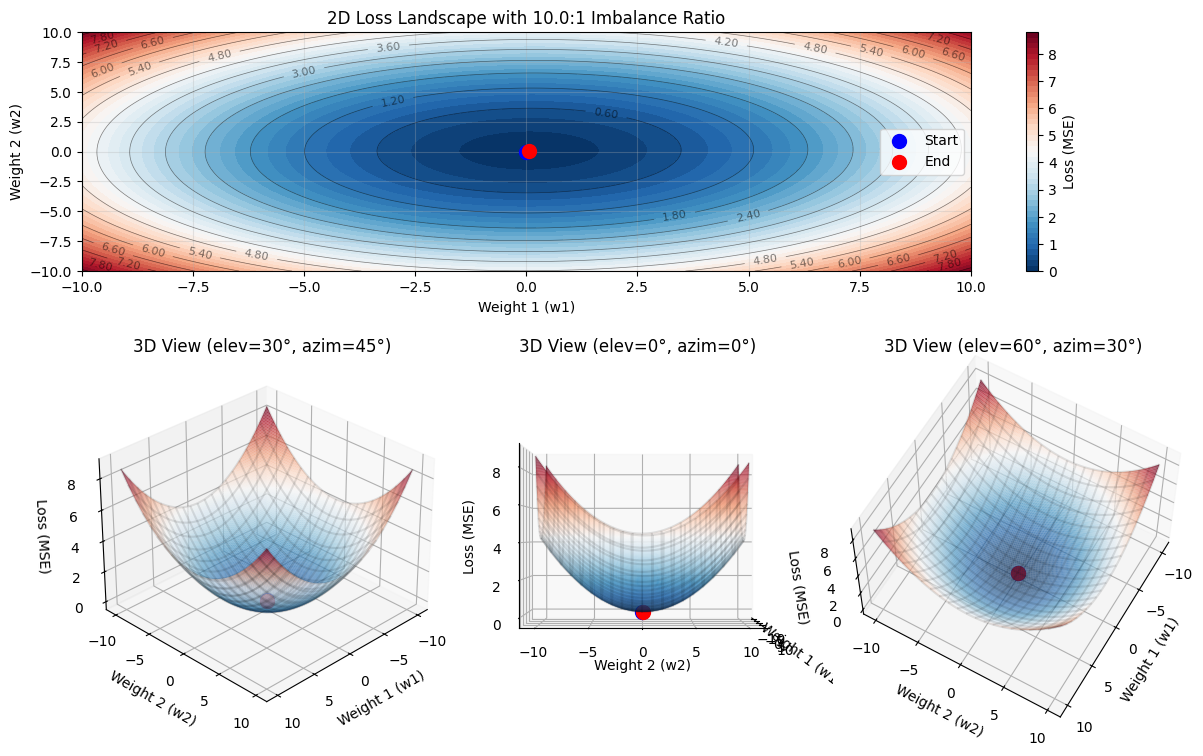

In [7]:


# Configuration
num_freq_samples = 500
freq_max_radius = 0.25
rare_min_radius = 0.75
noise_level = 0.1
val_size = 50


# Generate dataset
dataset = ImbalancedCircleDataset(
    num_freq_samples=num_freq_samples,
    freq_max_radius=freq_max_radius,
    rare_min_radius=rare_min_radius,
    noise_level=noise_level,
    val_size=val_size
)

imb_ratio = 10.0
lr = 1e-2

# Test with a single imbalance ratio
X_train, y_train = dataset.get_dataset(imbalance_ratio=imb_ratio)
X_val, y_val = dataset.get_validation_data()

dataset.plot_dataset(X_train, y_train, title=f"Dataset with {imb_ratio}:1 Imbalance Ratio")

# Train model
print(f"Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
model = create_simple_model()
history = train_model(model, X_train, y_train, X_val, y_val, lr=lr, epochs=50, batch_size=64)

# Plot results
plot_training_curves(history)

# Compute and plot loss landscape with more detail
W1, W2, Z = compute_loss_landscape(
    model, X_train, y_train, 
    w1_range=(-10, 10),
    w2_range=(-10, 10),
    grid_size=0.1,
    batch_size=1000
    )
plot_loss_landscape(W1, W2, Z, history['params'], title=f"Loss Landscape with {imb_ratio}:1 Imbalance Ratio")


In [ ]:


# Configuration
num_freq_samples = 10000
freq_max_radius = 0.2
rare_min_radius = 0.8
noise_level = 0.1
val_size = 1000
epochs = 20

# Analyze multiple imbalance ratios
imbalance_ratios = [1.0, 10.0, 50.0, 100.0, 200.0, 500.0, 1000.0]
results = analyze_imbalance_effects(
    imbalance_ratios,
    num_freq_samples=num_freq_samples,
    freq_max_radius=freq_max_radius,
    rare_min_radius=rare_min_radius,
    noise_level=noise_level,
    val_size=val_size,
    epochs=epochs)

# Plot comparison of results
plt.figure(figsize=(12, 8))
plt.plot(imbalance_ratios, results['final_train_loss'], 'b-', label='Final Train Loss')
plt.plot(imbalance_ratios, results['final_val_loss'], 'r-', label='Final Val Loss')
plt.plot(imbalance_ratios, results['overfit_degree'], 'g-', label='Overfitting Degree')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Imbalance Ratio (log scale)')
plt.ylabel('Loss (MSE, log scale)')
plt.title('Effect of Imbalance Ratio on Model Performance')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.show()

# Display selected loss landscapes
for i, ratio in enumerate(imbalance_ratios):
    idx = imbalance_ratios.index(ratio)
    W, B, Z, hist = results['loss_landscapes'][idx]
    plot_loss_landscape(W, B, Z, hist['params'], 
                        title=f"Loss Landscape with {ratio}:1 Imbalance Ratio")
    plot_training_curves(hist, title=f"Training Curves with {ratio}:1 Imbalance Ratio")



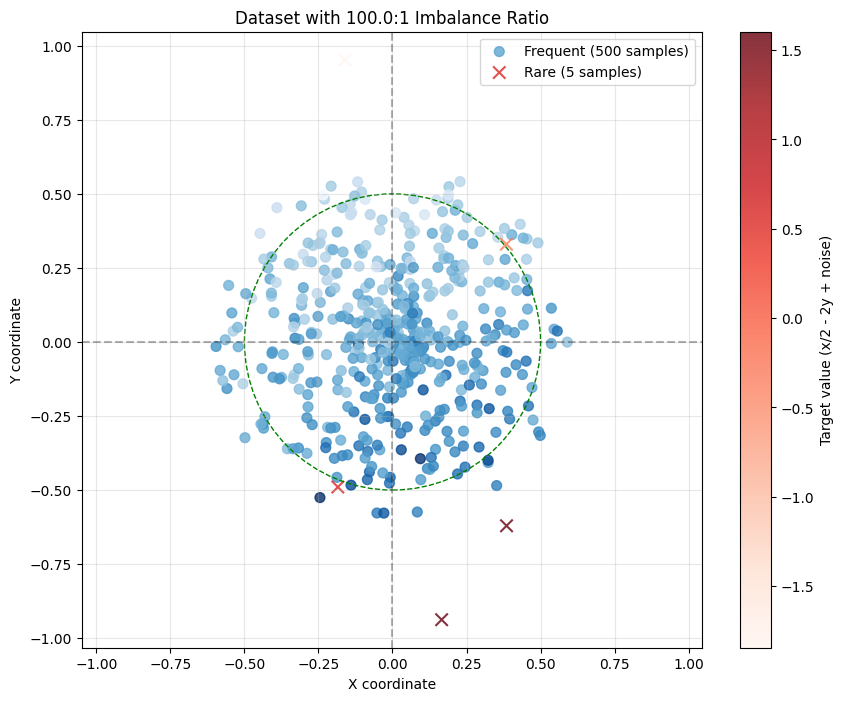

Training model with 404 training samples and 101 validation samples
Epoch 1/50 - train_loss: 0.479183 - val_loss: 0.500665 - weights: [0.0573, -0.0685]
Epoch 2/50 - train_loss: 0.460704 - val_loss: 0.479855 - weights: [0.1148, -0.1355]
Epoch 3/50 - train_loss: 0.443463 - val_loss: 0.460668 - weights: [0.1638, -0.2025]
Epoch 4/50 - train_loss: 0.427091 - val_loss: 0.442301 - weights: [0.2138, -0.2689]
Epoch 5/50 - train_loss: 0.411985 - val_loss: 0.425488 - weights: [0.2570, -0.3339]
Epoch 6/50 - train_loss: 0.398007 - val_loss: 0.410306 - weights: [0.2882, -0.3982]
Epoch 7/50 - train_loss: 0.384506 - val_loss: 0.395431 - weights: [0.3229, -0.4628]
Epoch 8/50 - train_loss: 0.371701 - val_loss: 0.381067 - weights: [0.3615, -0.5267]
Epoch 9/50 - train_loss: 0.360231 - val_loss: 0.368595 - weights: [0.3863, -0.5877]
Epoch 10/50 - train_loss: 0.349433 - val_loss: 0.356821 - weights: [0.4098, -0.6478]
Epoch 11/50 - train_loss: 0.339586 - val_loss: 0.346137 - weights: [0.4293, -0.7054]
Epoch 

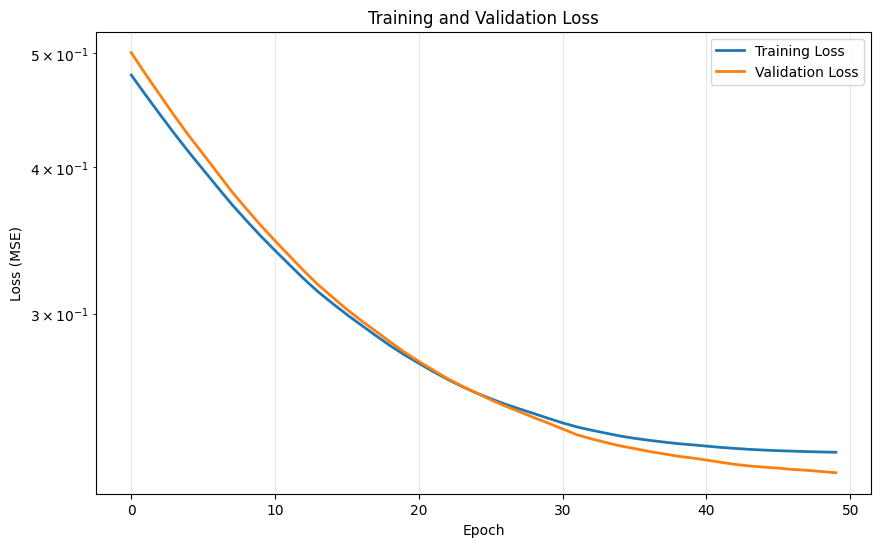

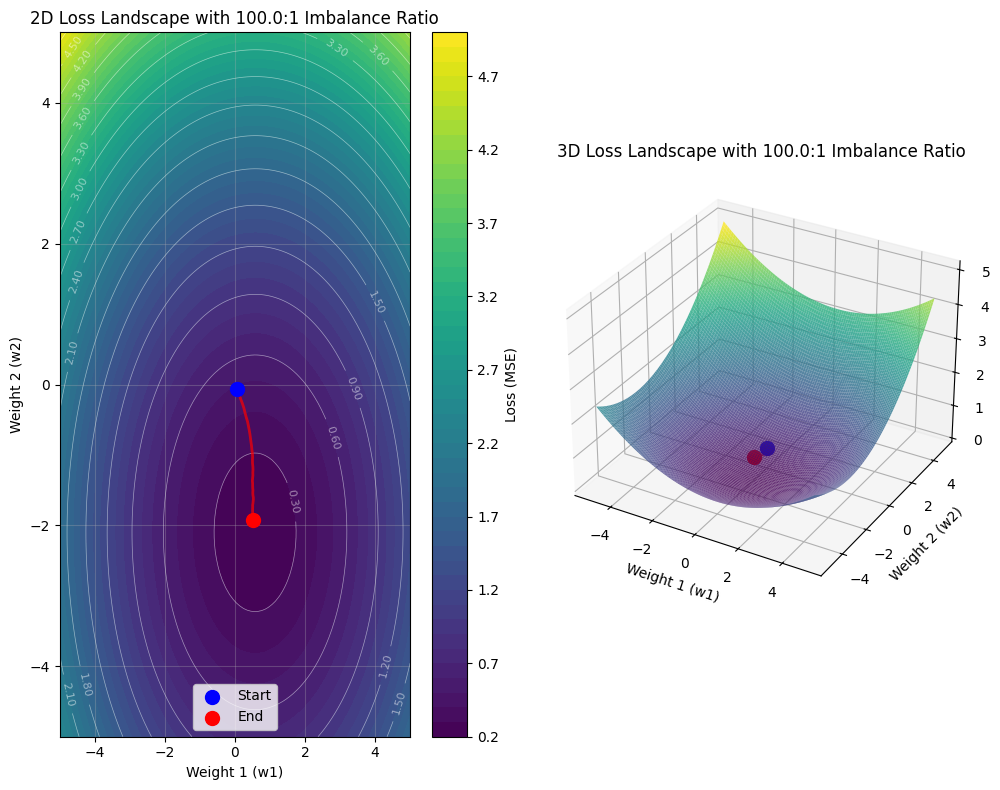

Processing imbalance ratio 1.0:1 (1/7)
  Training model with 16000 training samples and 4000 validation samples
Epoch 1/20 - train_loss: 0.008130 - val_loss: 0.008338 - weights: [0.4951, -1.7841]
Epoch 2/20 - train_loss: 0.000000 - val_loss: 0.000000 - weights: [0.5000, -1.9987]
Epoch 3/20 - train_loss: 0.000000 - val_loss: 0.000000 - weights: [0.5000, -2.0000]
Epoch 4/20 - train_loss: 0.000000 - val_loss: 0.000000 - weights: [0.5000, -2.0000]
Epoch 5/20 - train_loss: 0.000000 - val_loss: 0.000000 - weights: [0.5000, -2.0000]
Epoch 6/20 - train_loss: 0.000000 - val_loss: 0.000000 - weights: [0.5000, -2.0000]
Epoch 7/20 - train_loss: 0.000000 - val_loss: 0.000000 - weights: [0.5000, -2.0000]
Epoch 8/20 - train_loss: 0.000000 - val_loss: 0.000000 - weights: [0.5000, -2.0000]
Epoch 9/20 - train_loss: 0.000000 - val_loss: 0.000000 - weights: [0.5000, -2.0000]
Epoch 10/20 - train_loss: 0.000000 - val_loss: 0.000000 - weights: [0.5000, -2.0000]
Epoch 11/20 - train_loss: 0.000000 - val_loss: 

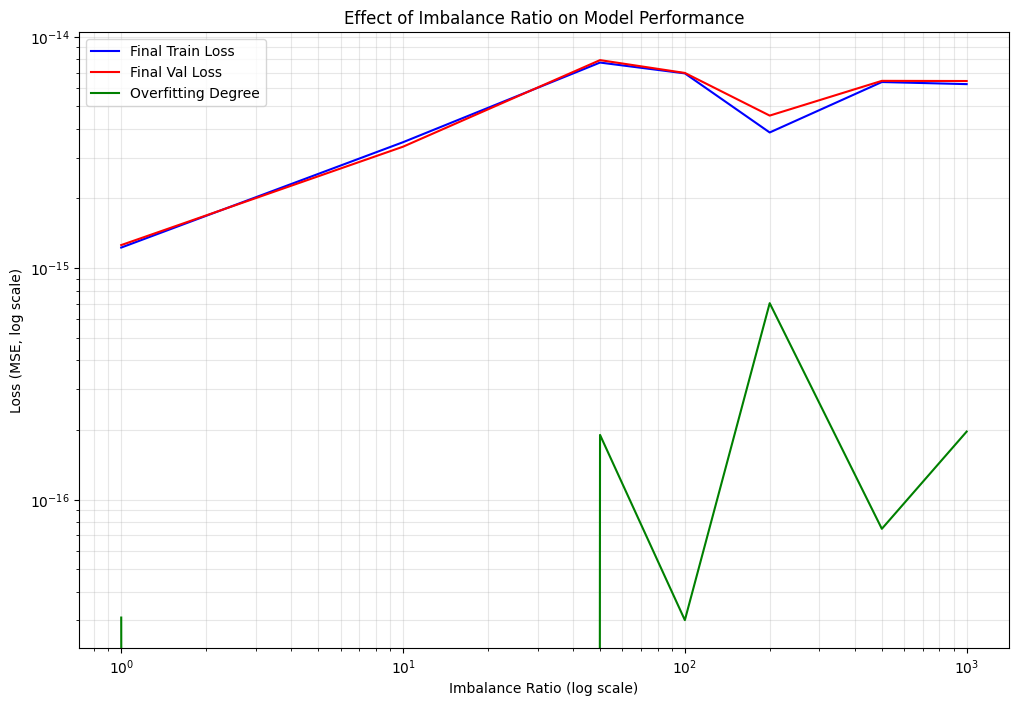

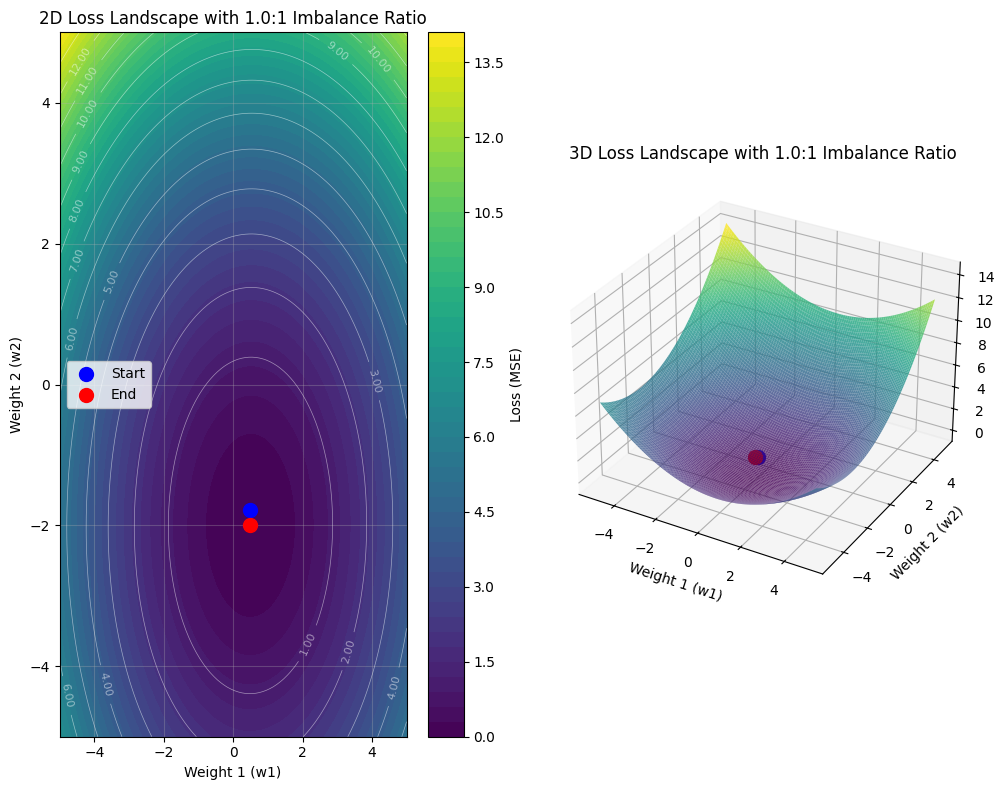

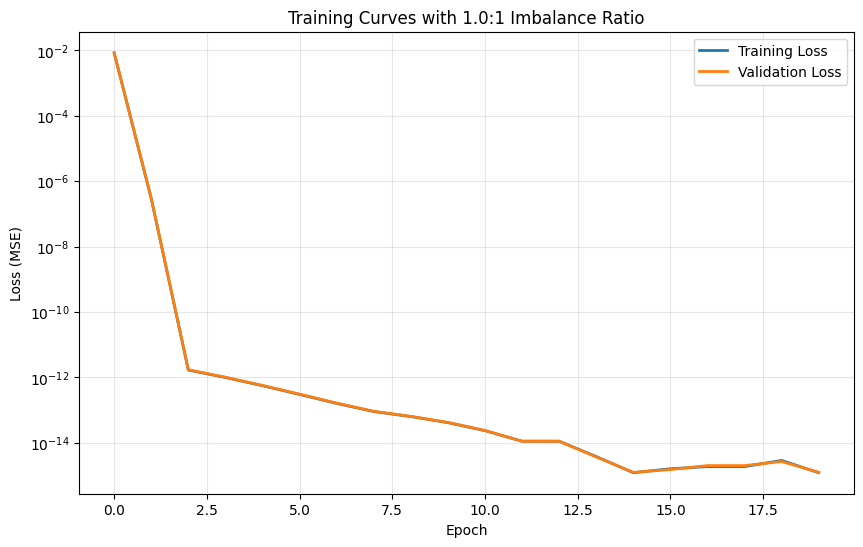

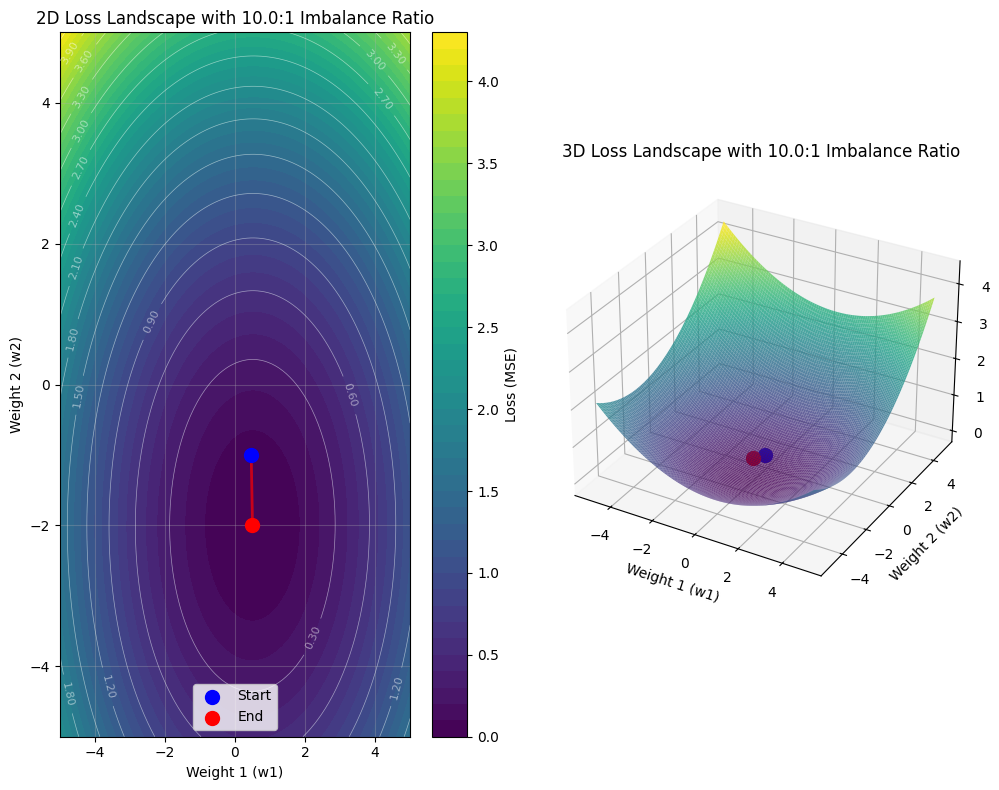

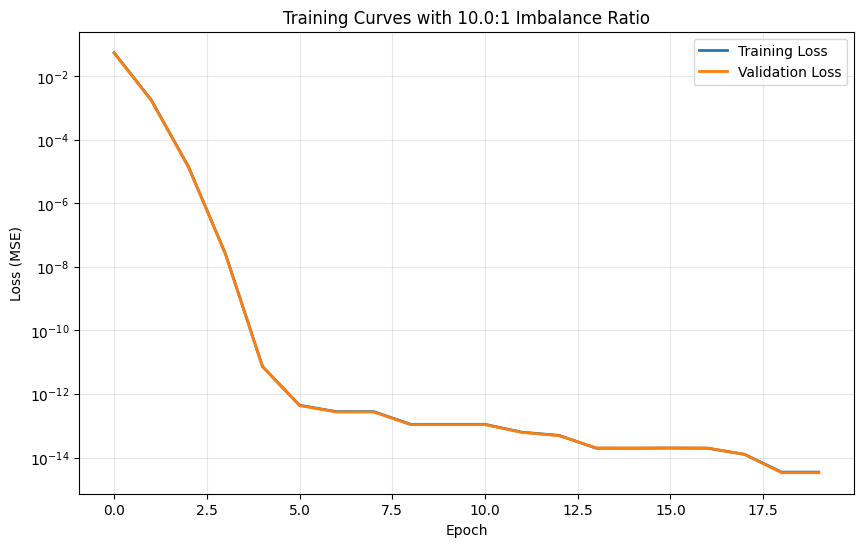

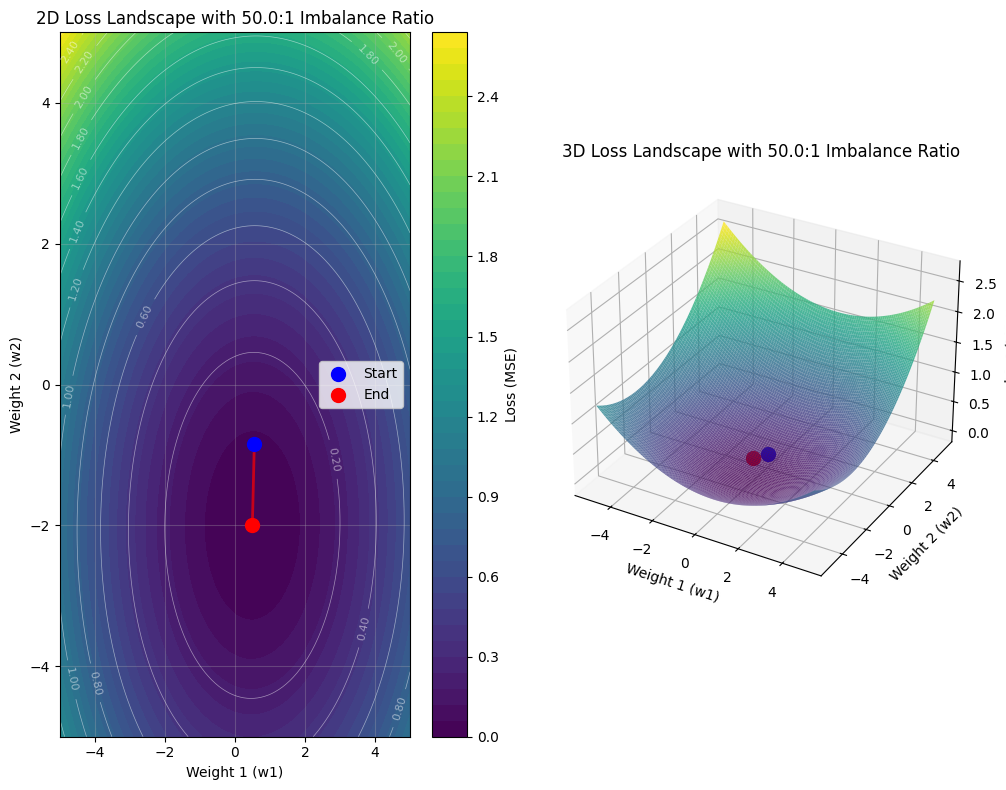

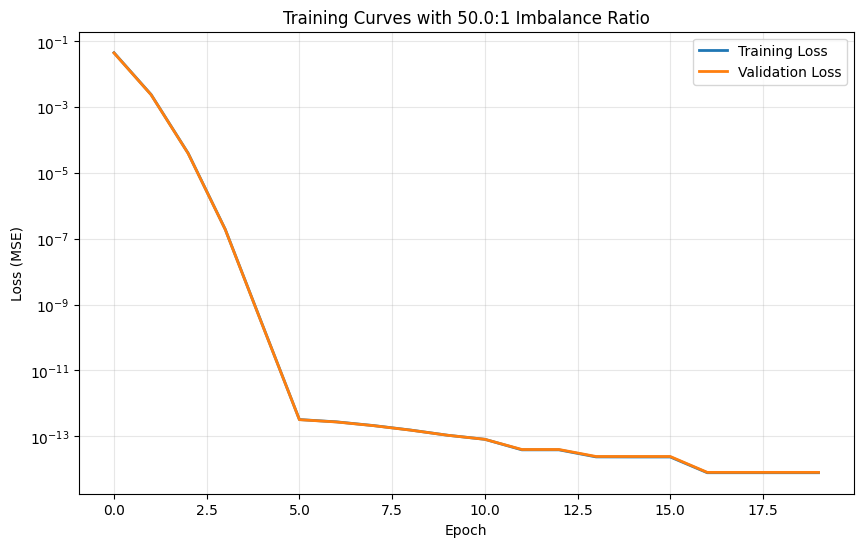

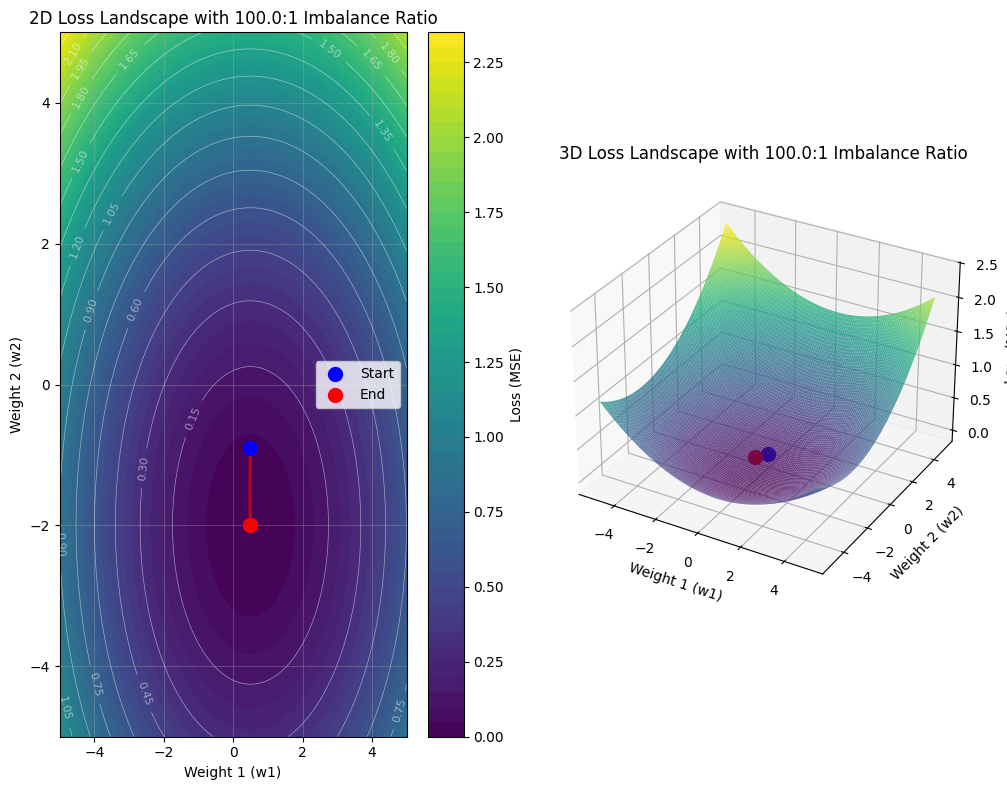

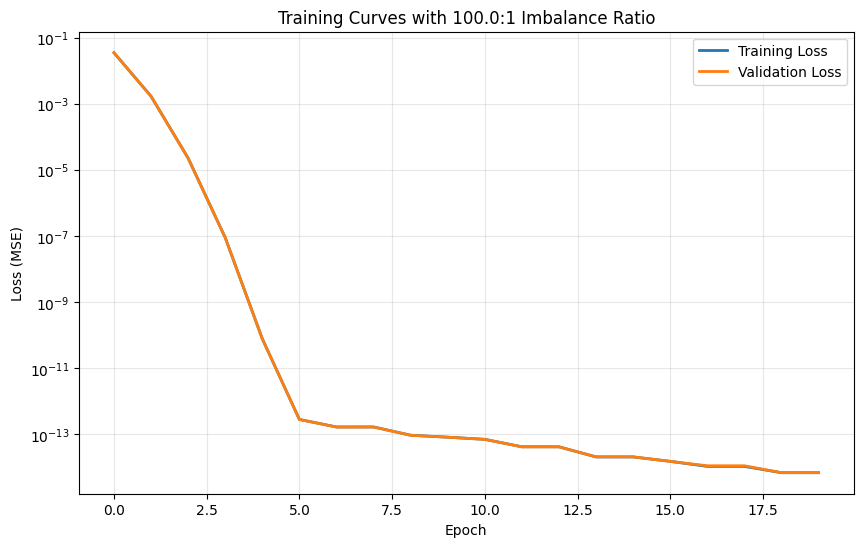

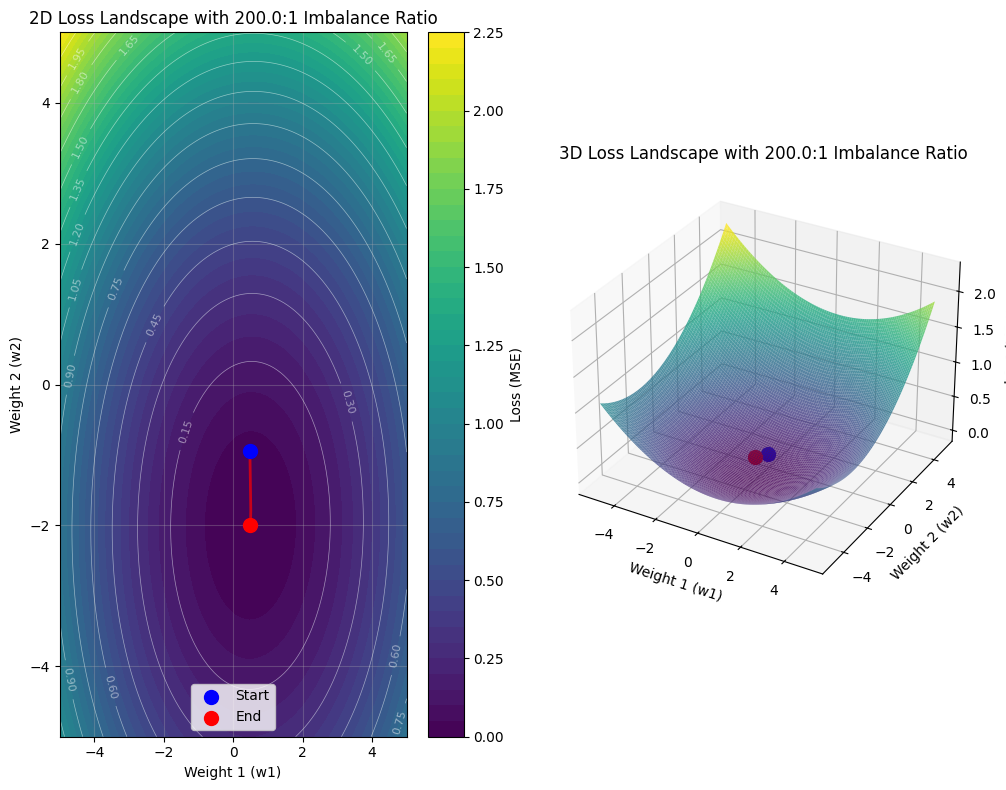

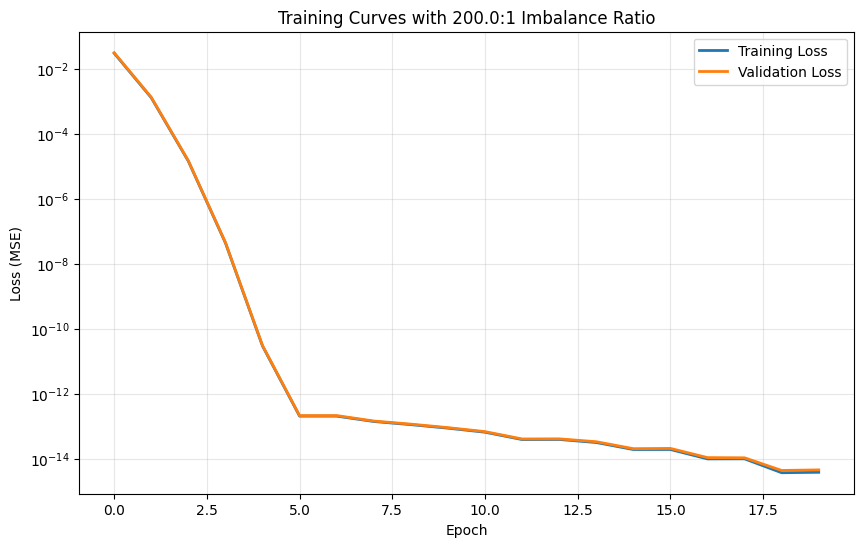

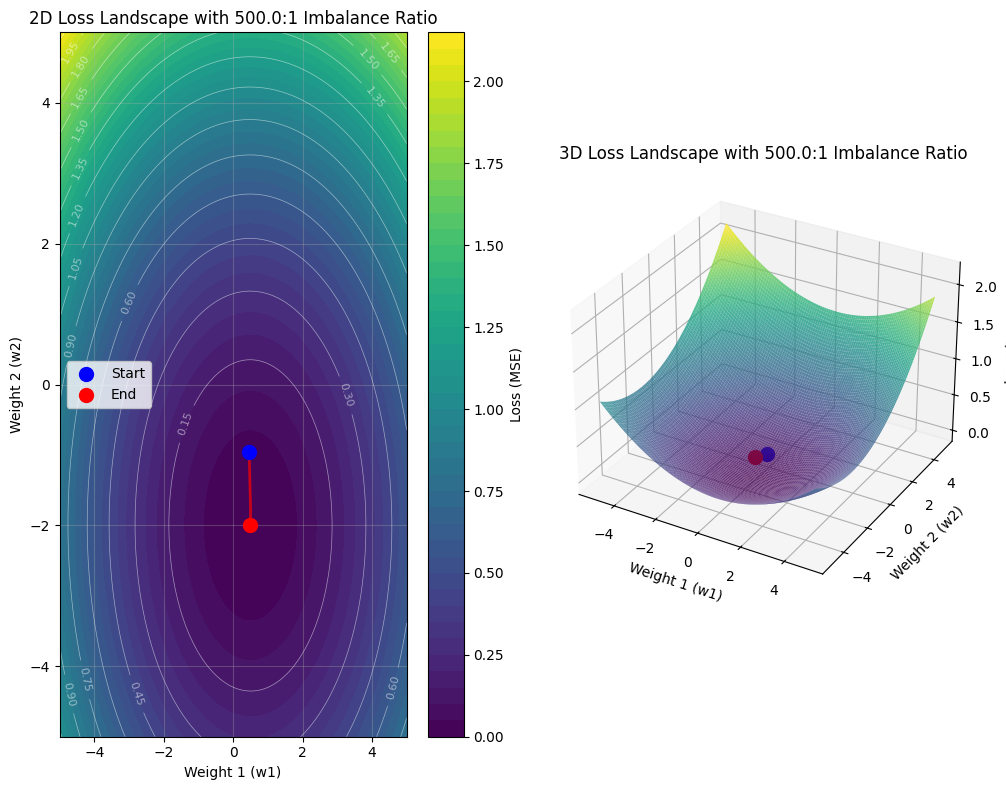

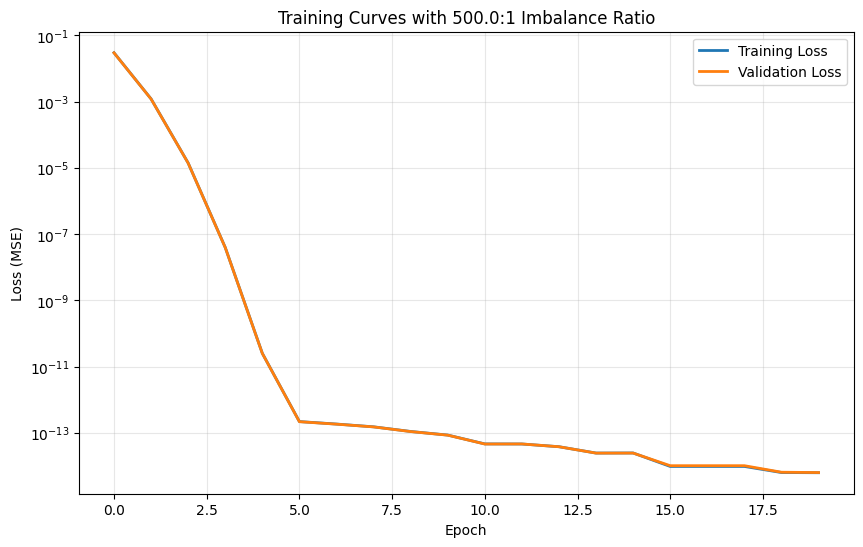

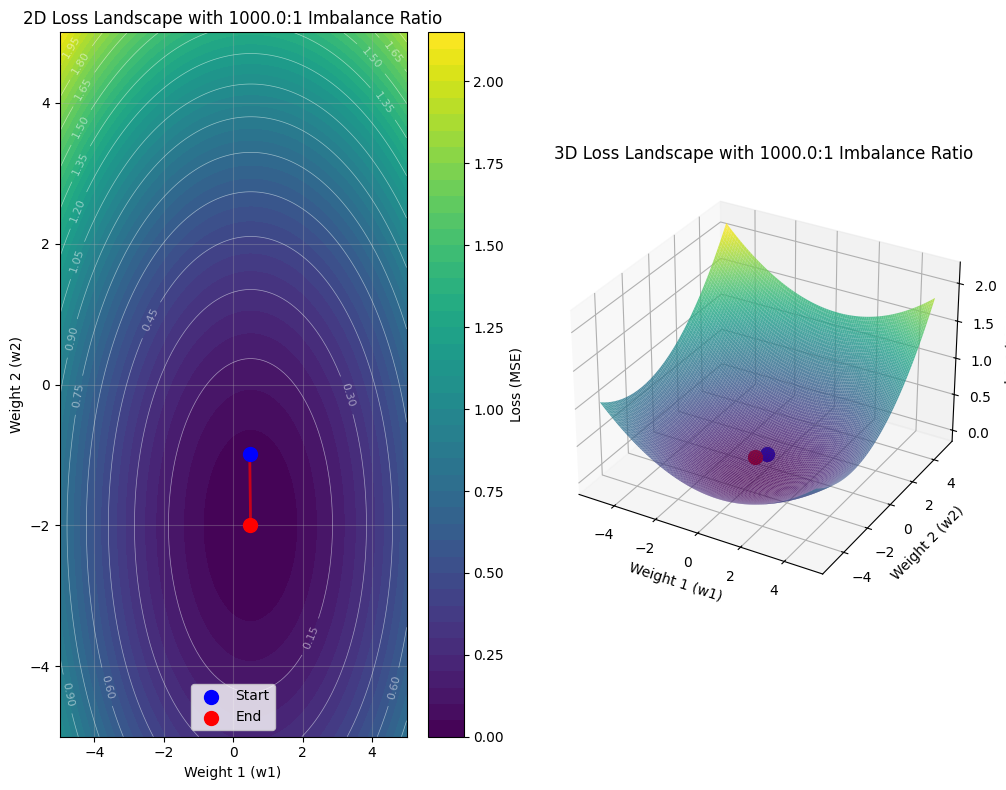

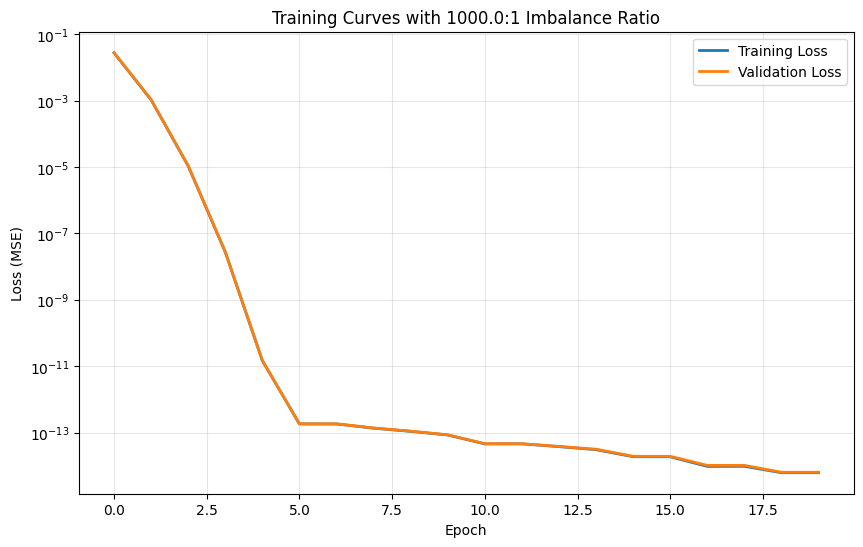